In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

from utilidades.graficar import ver_dispersion

In [3]:
train = pd.read_csv('data/train_limpio.csv')

In [4]:
X = train.drop(columns=['precio'])
y = train['precio']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Extra Trees Regressor

In [6]:
%%time
xtr = ExtraTreesRegressor(n_estimators=100, n_jobs=-1)
xtr.fit(X_train, y_train)

Wall time: 42 s


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

### Predicción del `y_test`

In [7]:
prediction_t = xtr.predict(X_test)
mean_absolute_error(y_test, prediction_t)

678025.3081749042

### Score

In [8]:
xtr.score(X_test, y_test)

0.7147574827502257

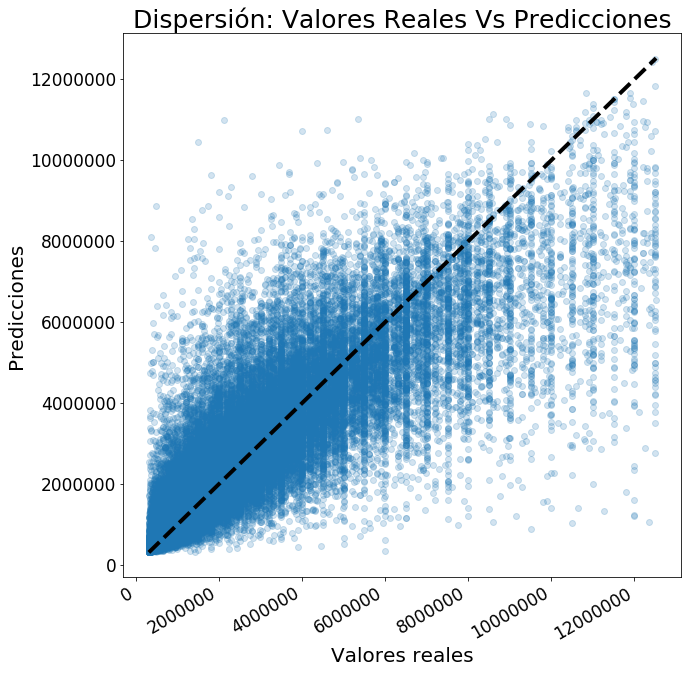

In [9]:
ver_dispersion(y_test, prediction_t)

### Validación (variable para modelo a entrenar = xtr)

In [10]:
%%time
transf = True
kfold = KFold(5, True, 42)
for i, (train_index, test_index) in enumerate(kfold.split(X)):
    # Se parte el dataset en dos, train y test, con el train entreno
    # y con el test evaluo como predice mi algoritmo
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    if transf:
        y_train = np.log(y_train)
    # Me creo una instancia del modelo y luego lo entreno con los datos(con fit(X,y))
    xtr = ExtraTreesRegressor(n_estimators=100, n_jobs=-1)
    xtr.fit(X_train, y_train)
    predicciones_t = xtr.predict(X_test)
    if transf:
        predicciones_t = np.exp(predicciones_t)

    # Me fijo como me da el resultado
    print(f"Error de fold N°{i} es : {round(mean_absolute_error(y_test, predicciones_t), 2)}")

Error de fold N°0 es : 666111.45
Error de fold N°1 es : 660929.37
Error de fold N°2 es : 664311.37
Error de fold N°3 es : 663999.0
Error de fold N°4 es : 659757.8
Wall time: 3min 48s
